# Notebook de Modelado - Proyecto de Pronósticos

En este notebook implementaremos los modelos de machine learning para generar pronósticos basados en los datos procesados.

## 1. Importación de librerías

In [1]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=".*FigureCanvasAgg is non-interactive.*"
)
import os
os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
np.set_printoptions(suppress=True)
np.random.seed(1)
import random
random.seed(1)
import pandas as pd
pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
from utilsforecast.plotting import plot_series as plot_series_utils
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])
from fpppy.utils import plot_series

# Configuraciones
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


from functools import partial
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from statsforecast.models import AutoTBATS
from statsforecast.models import AutoARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, Markdown, Image

# Importar función de carga desde el módulo etl
from src.etl import load_dict_from_csv

from src.modelling_tools import compile_models_output, evaluate_models_metrics

from src.modelling_tools import build_X_future_step, plot_ets_decomposition, plot_residual_analysis, perform_residual_tests, forecast_with_corrected_dates, create_hybrid_forecast, plot_forecast_with_intervals, calculate_annual_variation, plot_annual_comparison, export_data, plot_histogram_boxplot

2025-10-14 23:08:36.065 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-14 23:08:36.065 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


## 2. Carga de datos

In [2]:
# # Cargar todos los datasets usando la función existente
datasets = load_dict_from_csv("data/csv", parse_dates=True)

In [ ]:
matri = datasets["Ingresos Matrículas"]
# Ya no es necesario eliminar la última fila porque se eliminó septiembre del CSV original

# Filtrar datos desde enero 2022 en adelante
matri = matri[matri["Fecha"] >= "2022-01-01"].copy()
print(f"Datos filtrados desde 2022. Período: {matri['Fecha'].min()} a {matri['Fecha'].max()}")
print(f"Total de observaciones: {len(matri)}")

Datos filtrados desde 2022. Período: 2022-01-01 00:00:00 a 2025-08-01 00:00:00
Total de observaciones: 44


In [4]:
matri.rename(columns={"Fecha": "ds", "Ingresos Matrículas": "y"}, inplace=True)
matri["unique_id"] = 1

# # Comentar/descomentar si se quiere probar transformación logarítmica
# matri["y"] = np.log(matri["y"])

In [5]:
matri_x = matri.copy()

# Crear variable dummy para cambio de tarifa en enero 2025
matri_x["Cambio_tarifa"] = np.where(matri_x["ds"] >= "2025-01-01", 1, 0)

# Seleccionar columnas para el modelo (sin variables de pandemia)
cols_to_model = ["ds", "y", "unique_id", "Cambio_tarifa"]
matri_x = matri_x[cols_to_model]

# Aplicar transformación logarítmica
matri_x["y"] = np.log(matri_x["y"])

print(f"Variables en el modelo: {list(matri_x.columns)}")
print(f"Período de datos: {matri_x['ds'].min()} a {matri_x['ds'].max()}")
print(f"Total de observaciones: {len(matri_x)}")

matri_x

Variables en el modelo: ['ds', 'y', 'unique_id', 'Cambio_tarifa']
Período de datos: 2022-01-01 00:00:00 a 2025-08-01 00:00:00
Total de observaciones: 44


,ds,y,unique_id,Cambio_tarifa
48,2022-01-01,18.442,1,0
49,2022-02-01,18.669,1,0
50,2022-03-01,18.543,1,0
51,2022-04-01,18.638,1,0
52,2022-05-01,18.543,1,0
53,2022-06-01,18.489,1,0
54,2022-07-01,18.508,1,0
55,2022-08-01,18.660,1,0
56,2022-09-01,18.555,1,0
57,2022-10-01,18.493,1,0


📊 ESTADÍSTICAS DESCRIPTIVAS
N observaciones: 44
Media: 107927536.36 | Mediana: 106710000.00
Desv. Estándar: 26459593.36
Q1: 94904250.00 | Q3: 124485750.00 | IQR: 29581500.00
Min: 41939000.00 | Max: 182185000.00
Outliers: 2 (4.5%)


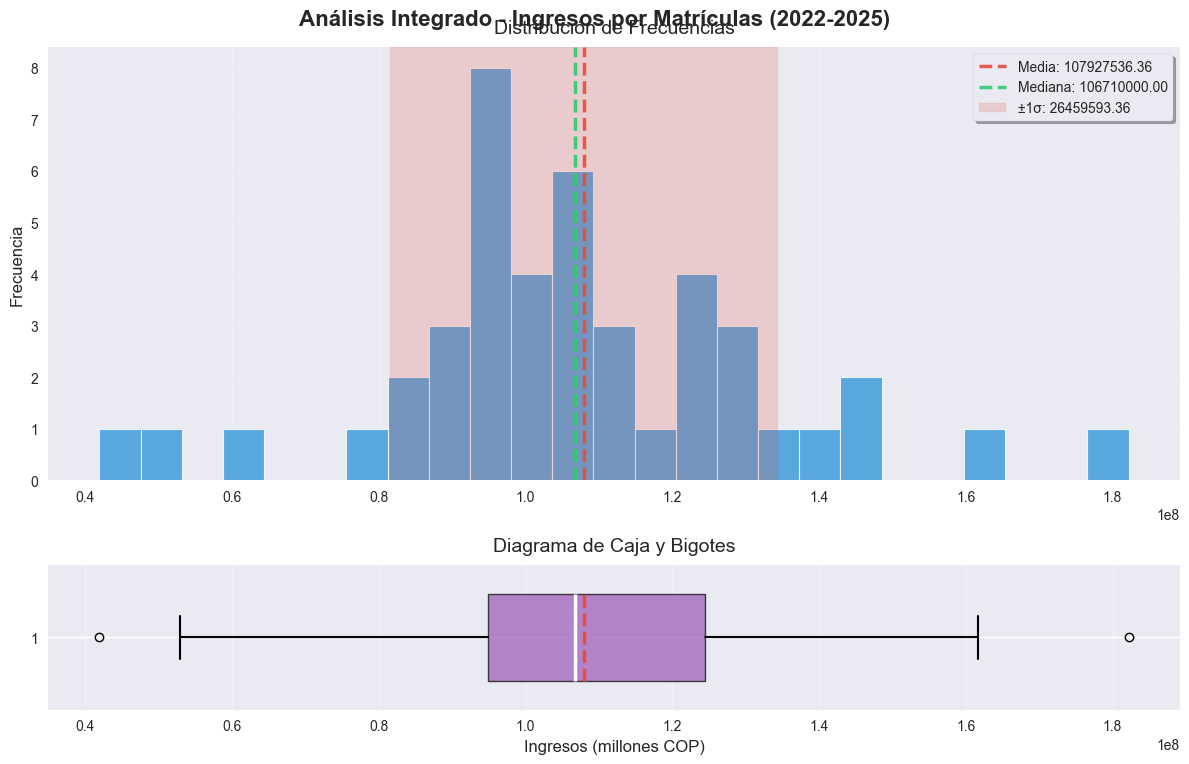

In [6]:
# Ejemplo de uso con layout vertical (más integrado)
fig, axes = plot_histogram_boxplot(
    df=matri, 
    column='y', 
    title='Análisis Integrado - Ingresos por Matrículas (2022-2025)',
    xlabel='Ingresos (millones COP)',
    ylabel='Frecuencia',
    bins=25,
    figsize=(12, 8),
    layout='vertical'  # Histograma arriba, boxplot abajo (más integrado)
)

plt.show()

📊 ESTADÍSTICAS DESCRIPTIVAS
N observaciones: 44
Media: 18.46 | Mediana: 18.49
Desv. Estándar: 0.27
Q1: 18.37 | Q3: 18.64 | IQR: 0.27
Min: 17.55 | Max: 19.02
Outliers: 3 (6.8%)


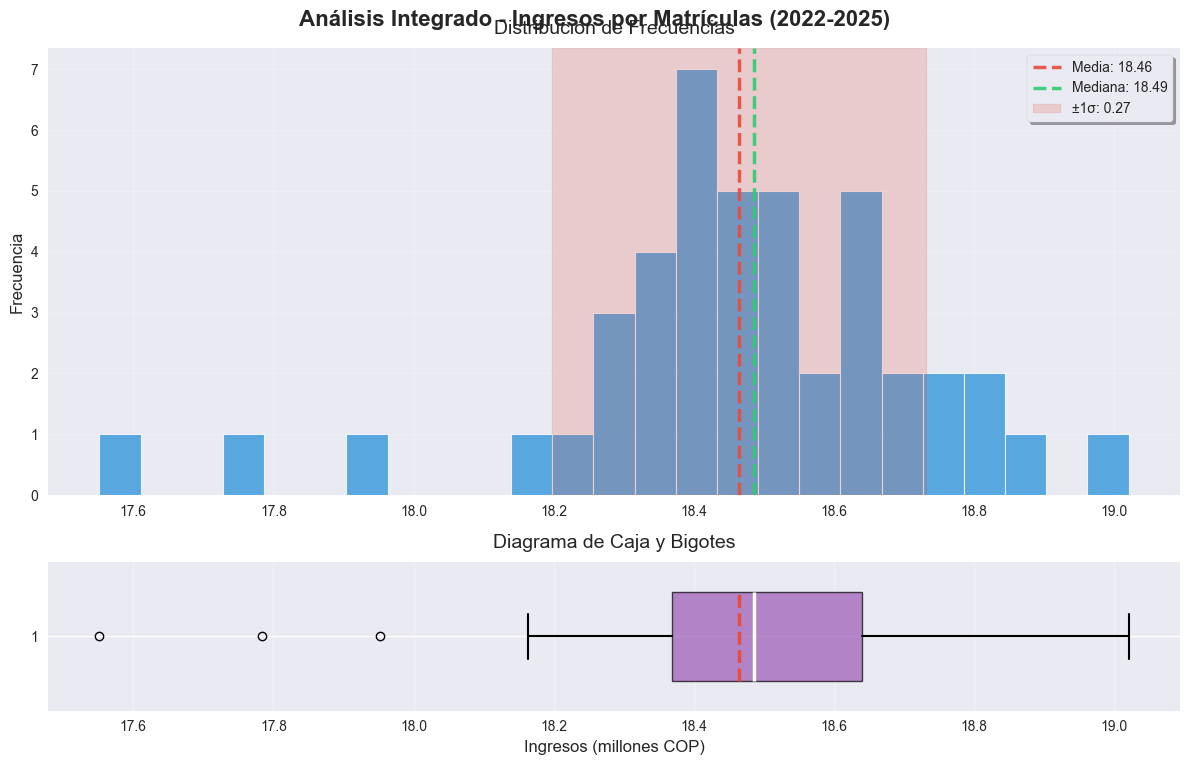

In [7]:
# Ejemplo de uso con layout vertical (más integrado)
fig, axes = plot_histogram_boxplot(
    df=matri_x, 
    column='y', 
    title='Análisis Integrado - Ingresos por Matrículas (2022-2025)',
    xlabel='Ingresos (millones COP)',
    ylabel='Frecuencia',
    bins=25,
    figsize=(12, 8),
    layout='vertical'  # Histograma arriba, boxplot abajo (más integrado)
)

plt.show()

# 3. Modelación

In [8]:
import pandas as pd

from statsforecast import StatsForecast
from statsforecast.models import AutoETS

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mape

## Sin exógenas

### Model config

In [9]:
import inspect
from utilsforecast.evaluation import evaluate
print(inspect.signature(evaluate))
# ---------------------------
# Config
# ---------------------------
H = 16                 # forecast horizon = 16 months (de septiembre 2025 a diciembre 2026)
SEASON_LEN = 12        # for ETS seasonality
# ---------------------------
# ETS models (ANM/AAM excluded)
# ---------------------------
models = [
    # ===== ETS que ya tienes =====
    # No seasonality
    AutoETS(season_length=SEASON_LEN, model="ANN", alias="ANN"),
    AutoETS(season_length=SEASON_LEN, model="AAN", alias="AAN"),
    AutoETS(season_length=SEASON_LEN, model="AAN", damped=True, alias="AANd"),
    AutoETS(season_length=SEASON_LEN, model="MNN", alias="MNN"),
    AutoETS(season_length=SEASON_LEN, model="MAN", alias="MAN"),
    AutoETS(season_length=SEASON_LEN, model="MAN", damped=True, alias="MANd"),
    # Additive seasonality
    AutoETS(season_length=SEASON_LEN, model="ANA", alias="ANA"),
    AutoETS(season_length=SEASON_LEN, model="AAA", alias="AAA"),
    AutoETS(season_length=SEASON_LEN, model="AAA", damped=True, alias="AAAd"),
    AutoETS(season_length=SEASON_LEN, model="MAA", alias="MAA"),
    AutoETS(season_length=SEASON_LEN, model="MAA", damped=True, alias="MAAd"),
    # Multiplicative seasonality (requires y > 0)
    AutoETS(season_length=SEASON_LEN, model="MAM", alias="MAM"),
    AutoETS(season_length=SEASON_LEN, model="MAM", damped=True, alias="MAMd"),
    AutoETS(season_length=SEASON_LEN, model="MMM", alias="MMM"),
    AutoETS(season_length=SEASON_LEN, model="MMM", damped=True, alias="MMMd"),


    # ARIMA FAMILY
    AutoARIMA(stepwise=False, approximation=False, alias="auto", season_length=12),


    # ===== TBATS family ===== Después de ejecutarlo, TBATS no mejora nada en este caso y tarda en ejecutarse =====
    # Selección automática (prueba con/sin Box-Cox, tendencia, amortiguación y ARMA via AIC)
    AutoTBATS(season_length=[SEASON_LEN], alias="AutoTBATS"),
    # Variante fija: forzar Box-Cox y ARMA si quieres comparar contra la auto
    AutoTBATS(season_length=[SEASON_LEN], use_boxcox=True, use_arma_errors=True, alias="TBATS_BC_ARMA"),
]

(df: ~AnyDFType, metrics: List[Callable], models: Optional[List[str]] = None, train_df: Optional[~AnyDFType] = None, level: Optional[List[int]] = None, id_col: str = 'unique_id', time_col: str = 'ds', target_col: str = 'y', agg_fn: Optional[str] = None) -> ~AnyDFType


### Model Fitting

In [10]:
sf = StatsForecast(models=models, freq="M")
# Usar la función wrapper para corregir las fechas de pronóstico
fc = forecast_with_corrected_dates(sf, df=matri, h=H, level=[90, 95], fitted=True, freq='M')
fitted_values = sf.forecast_fitted_values()
models_dict = compile_models_output(fitted_values)

In [11]:
pronostico_ets = fc.copy()

### Model Evaluation

In [12]:
# Evaluar modelos con métricas (RMSE, MAE, MAPE)
metrics_results_01 = evaluate_models_metrics(models_dict)
pd.set_option('display.float_format', '{:.2f}'.format)
metrics_results_01

,model,rmse,mae,mape
0,AutoTBATS,11359564.00,9720171.00,9.38
1,auto,12282433.00,7811766.00,7.03
2,AAAd,13757942.00,9865983.00,8.52
3,AAA,13757942.00,9865983.00,8.52
4,MAAd,14402004.00,10182124.00,8.66
5,MAA,14402004.00,10182124.00,8.66
6,TBATS_BC_ARMA,15419553.00,12148963.00,11.59
7,ANA,15644654.00,11308718.00,9.61
8,MAM,17453292.00,13846323.00,12.95
9,MAMd,17665612.00,13496847.00,12.47


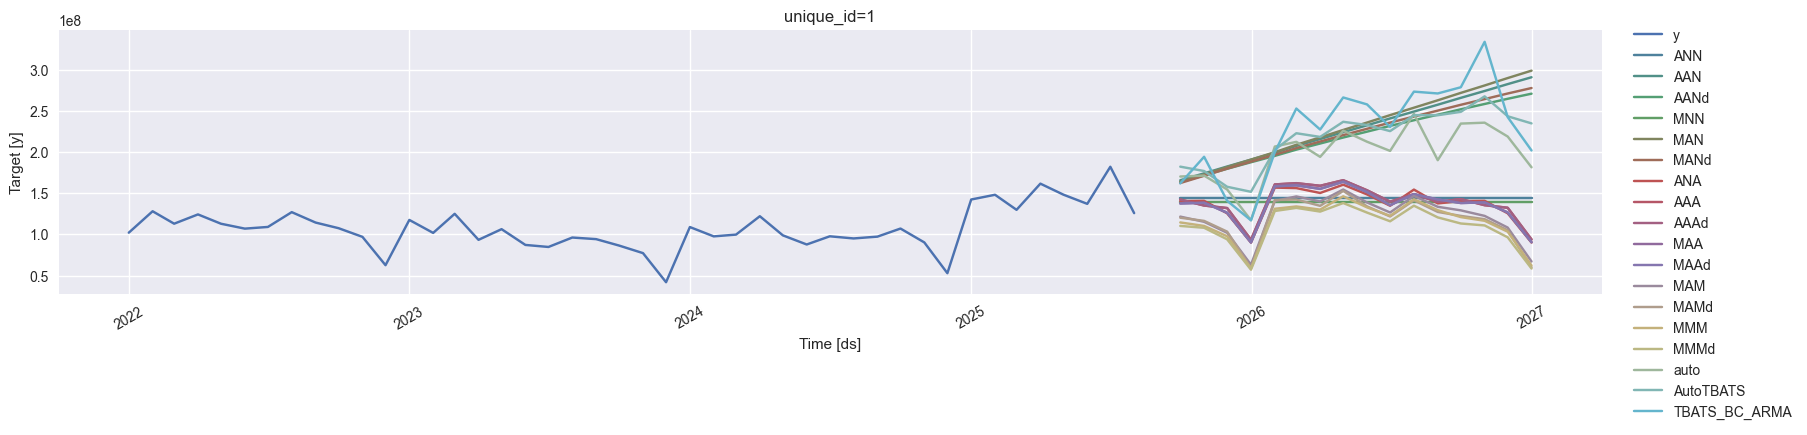

In [13]:
sf = sf.fit(matri)
plot_series(matri, fc)

In [14]:
fitted_best_model_01 = sf.fitted_[0,6].model_

## Con exógenas

### Model config

In [15]:
import inspect
from utilsforecast.evaluation import evaluate
print(inspect.signature(evaluate))
# ---------------------------
# Config
# ---------------------------

H = 16  # forecast horizon = 16 months (de septiembre 2025 a diciembre 2026)
models = [
    # ARIMA FAMILY
    AutoARIMA(stepwise=False, approximation=False, alias="auto", season_length=12),

]

(df: ~AnyDFType, metrics: List[Callable], models: Optional[List[str]] = None, train_df: Optional[~AnyDFType] = None, level: Optional[List[int]] = None, id_col: str = 'unique_id', time_col: str = 'ds', target_col: str = 'y', agg_fn: Optional[str] = None) -> ~AnyDFType


### Model Fitting

In [16]:
sf = StatsForecast(models=models, freq="M")

sf = sf.fit(
    df=matri_x,
    target_col="y",
)

# Crear X_future con valores específicos para la variable exógena
X_future = build_X_future_step(
    matri_x, 
    H, 
    freq='M', 
    exog_values={
        'Cambio_tarifa': 1,    # Suponemos que el cambio tarifario continúa
    })
          

# Generar pronósticos con variables exógenas usando la función wrapper
fc = forecast_with_corrected_dates(sf, df=matri_x, h=H, level=[90, 95], fitted=True, X_df=X_future, freq='M')

pronostico_auto_arima_x = fc.copy()

# Obtener valores ajustados para análisis posterior
fitted_values = sf.forecast_fitted_values()
models_dict = compile_models_output(fitted_values)

### Model Evaluation

In [17]:
# Evaluar modelos con métricas (RMSE, MAE, MAPE)
metrics_results = evaluate_models_metrics(models_dict)
pd.set_option('display.float_format', '{:.2f}'.format)
metrics_results

,model,rmse,mae,mape
0,auto,0.12,0.08,0.44


### Decomposition

In [18]:
fitted_best_model_02 = sf.fitted_[0,0].model_

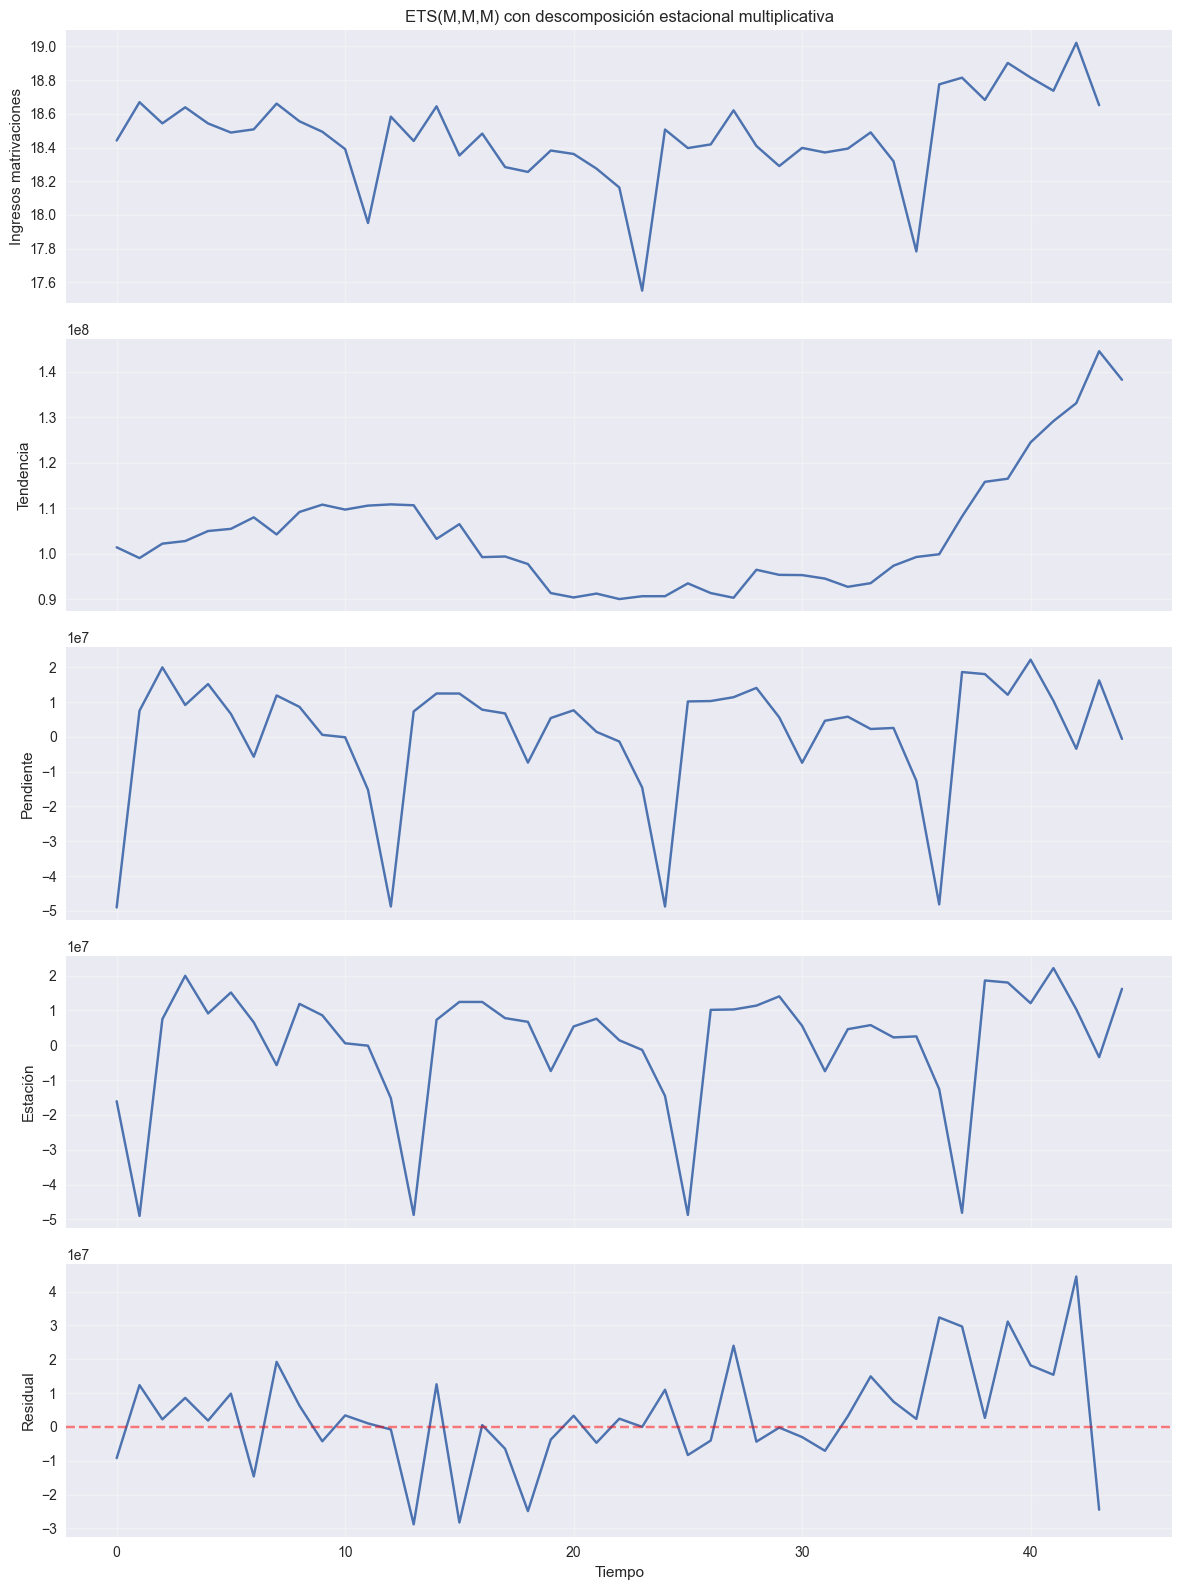

In [19]:
# Crear gráfico de descomposición usando la función
fig, axes = plot_ets_decomposition(
    original_data=matri_x["y"].values,
    fitted_model=fitted_best_model_01,
    title="ETS(M,M,M) con descomposición estacional multiplicativa",
    y_label="Ingresos matrivaciones"
)
plt.show()

### Residuals check

##### Sarimax model

In [20]:
# Importar librerías necesarias para análisis de residuales
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox  # Importación correcta para ljungbox
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import numpy as np

# Extraer residuales
residuales_2 = fitted_best_model_02["residuals"]
fitted_val_2 = models_dict["auto"]["fitted"].values
# Calcular valores ajustados correctamente
original_values_2 = matri["y"].values


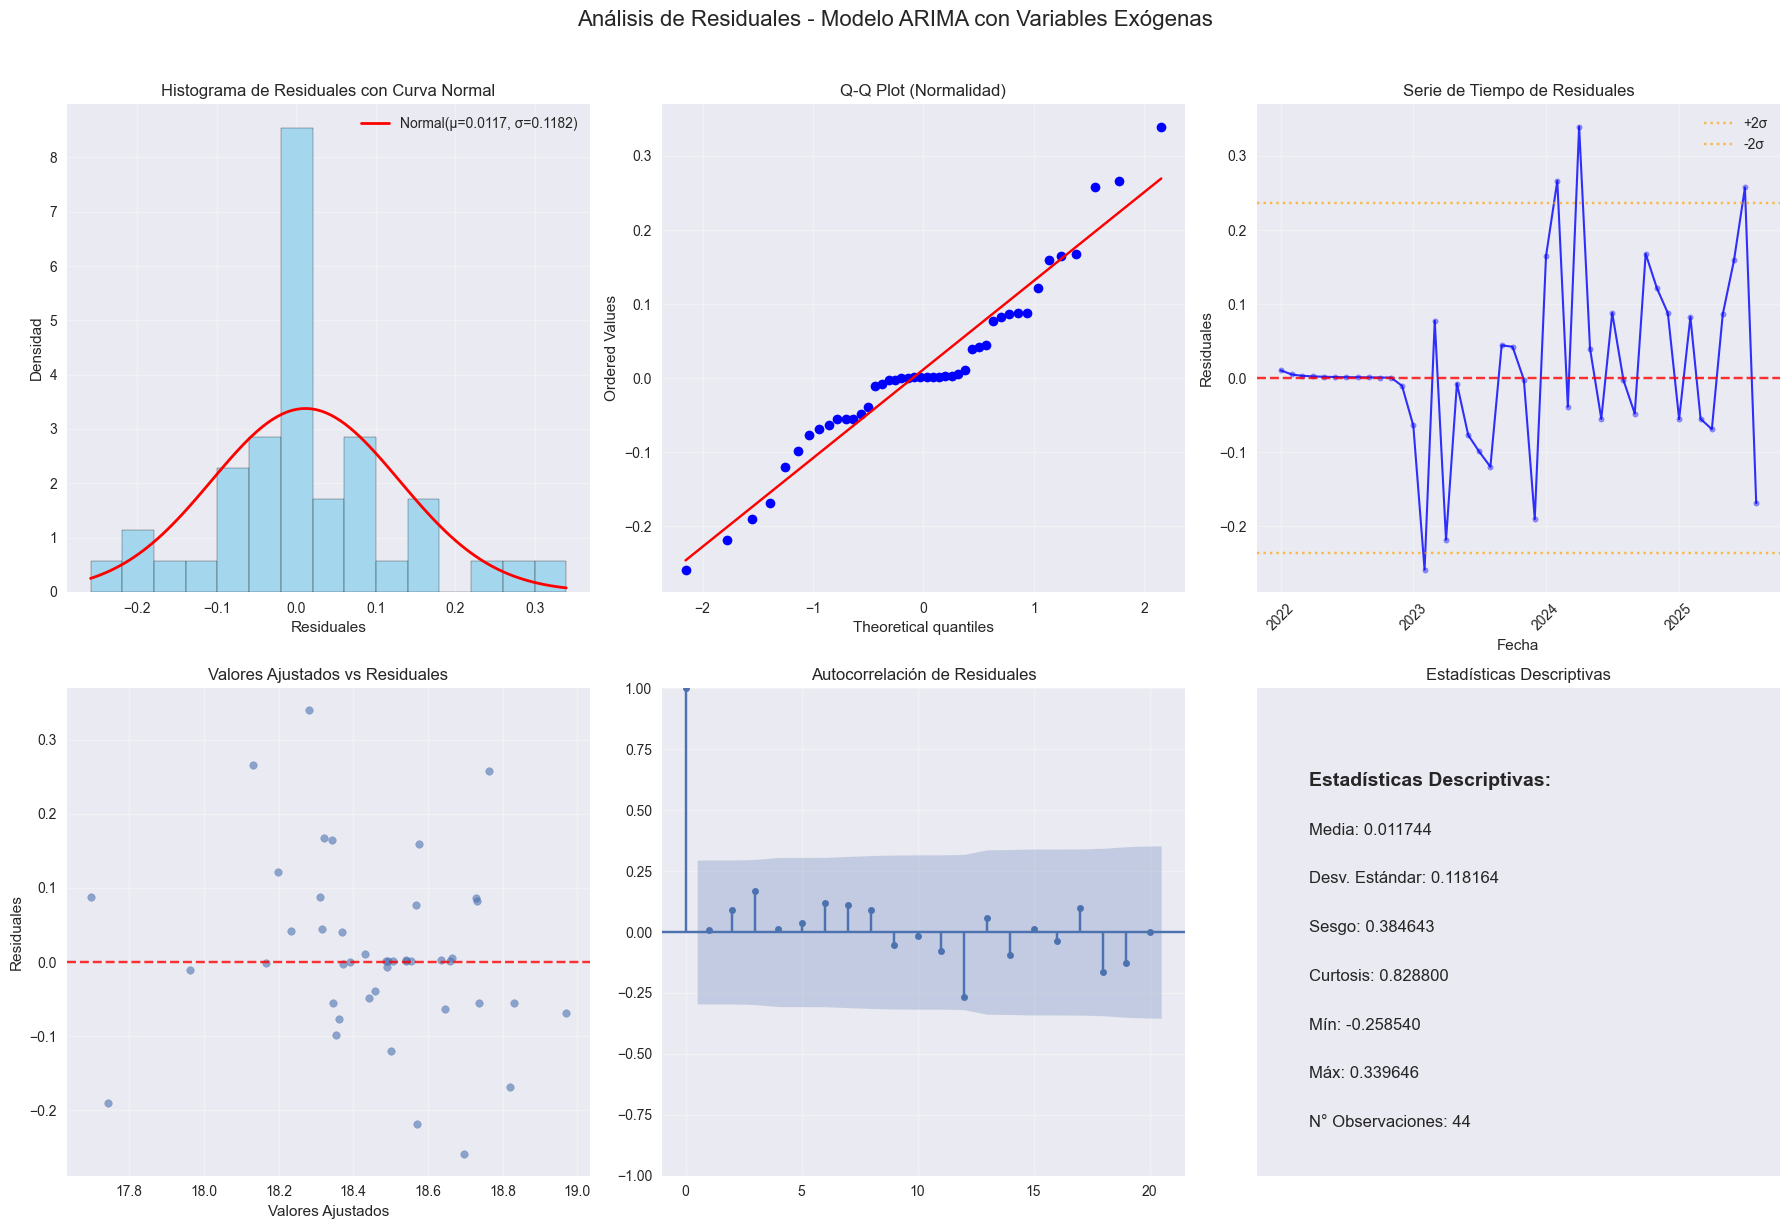

In [21]:
# Crear análisis gráfico de residuales para el modelo ARIMA con variables exógenas
fig, axes = plot_residual_analysis(
    residuals=residuales_2,
    fitted_values=fitted_val_2,
    title="Análisis de Residuales - Modelo ARIMA con Variables Exógenas",
    bins=15,
    lags=20,
    dates=matri_x["ds"]  # Agregar las fechas para el eje x del gráfico temporal
)
plt.show()

In [22]:
# Importar librerías necesarias para análisis de residuales
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox  # Importación correcta para ljungbox
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import numpy as np

# Extraer residuales
residuales = fitted_best_model_01["residuals"]
fitted_val = models_dict["auto"]["fitted"].values
# Calcular valores ajustados correctamente
original_values = matri["y"].values


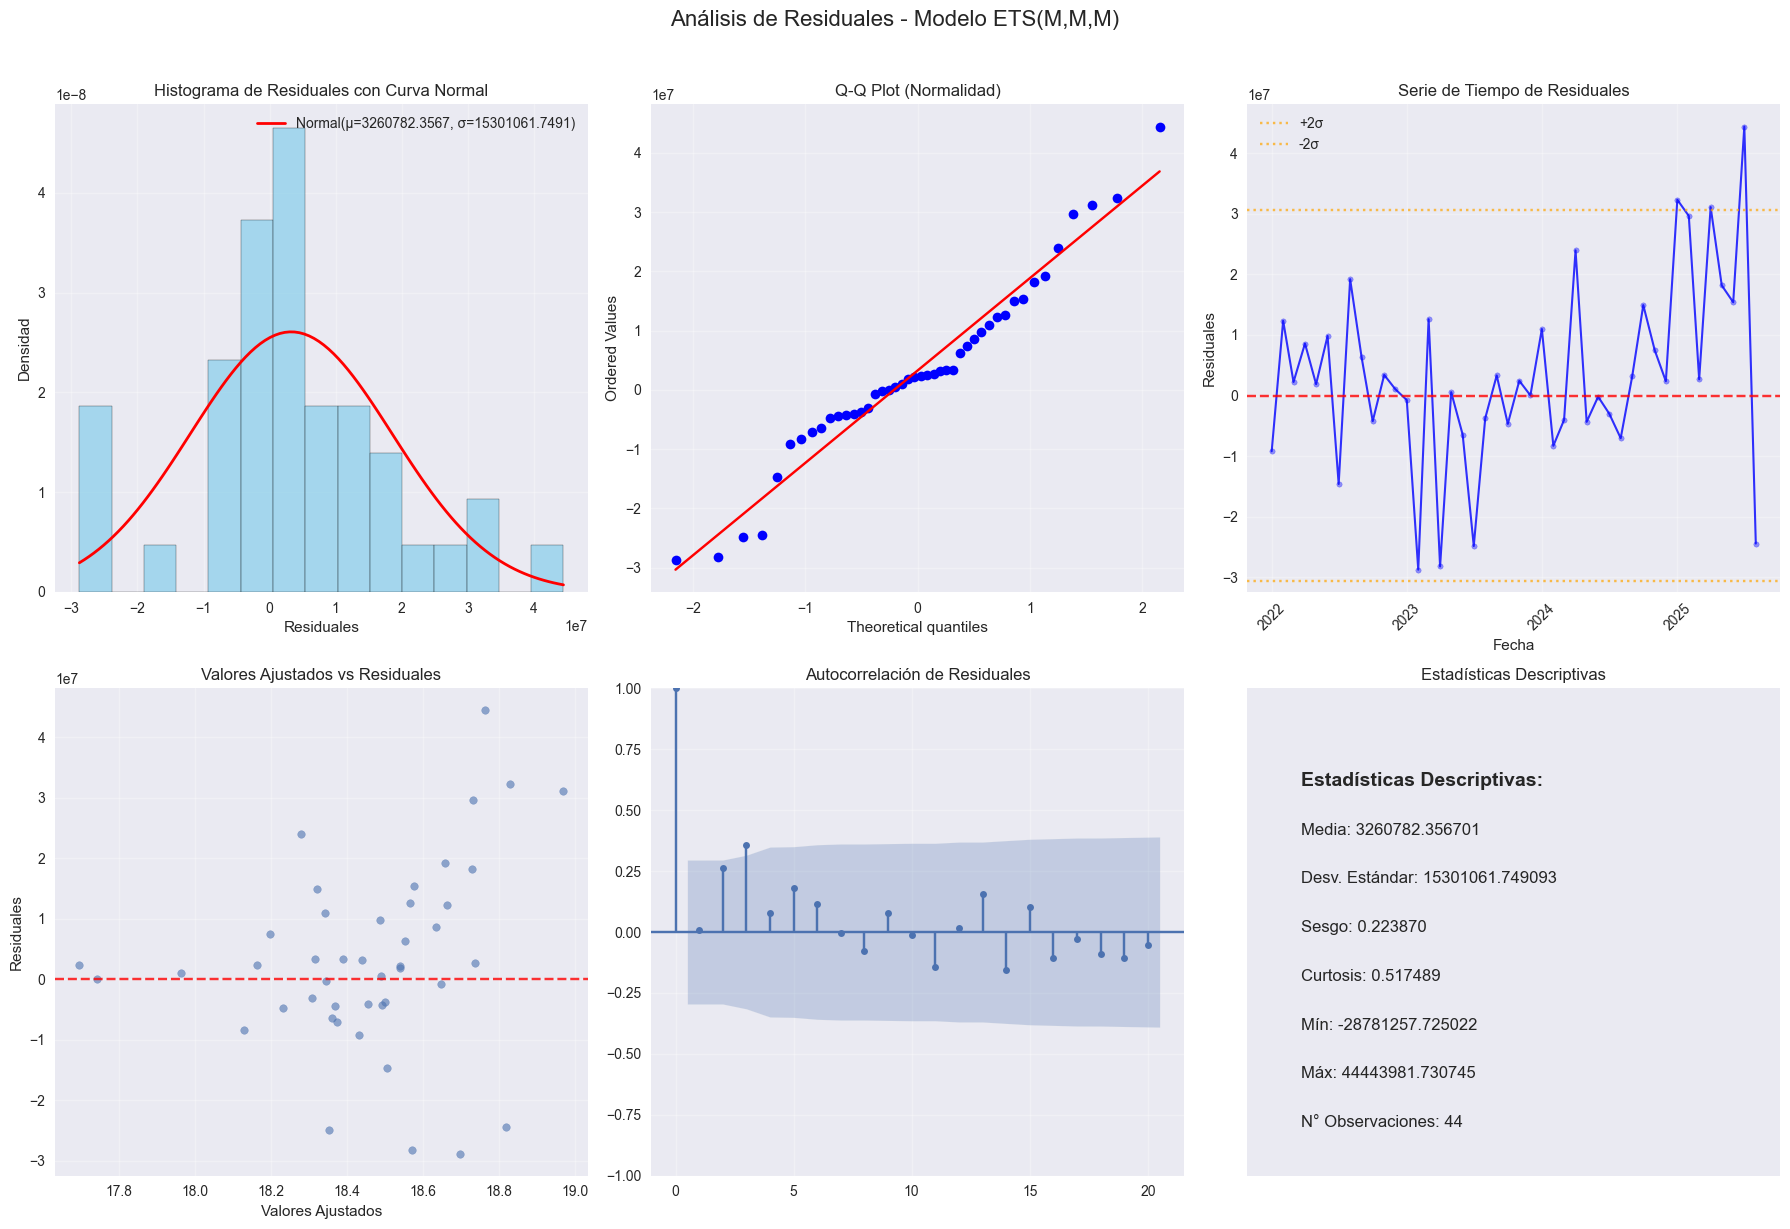

In [23]:
# Crear análisis gráfico de residuales usando la función
fig, axes = plot_residual_analysis(
    residuals=residuales,
    fitted_values=fitted_val,
    title="Análisis de Residuales - Modelo ETS(M,M,M)",
    bins=15,
    lags=20,
    dates=matri["ds"]  # Agregar las fechas para el eje x del gráfico temporal
)
plt.show()

In [24]:
# Realizar todas las pruebas estadísticas de residuales usando la función
results_residuales = perform_residual_tests(
    residuals=residuales,
    title="Análisis Estadístico de Residuales - Modelo ETS(M,M,M)",
    alpha=0.05
)

ANÁLISIS ESTADÍSTICO DE RESIDUALES - MODELO ETS(M,M,M)

1. PRUEBAS DE NORMALIDAD:
------------------------------
Shapiro-Wilk Test:
   Estadístico: 0.962869
   p-valor: 0.166485
   Conclusión: No se rechaza normalidad

Jarque-Bera Test:
   Estadístico: 0.858489
   p-valor: 0.651001
   Sesgo: 0.223870
   Curtosis: 3.517489
   Conclusión: No se rechaza normalidad

Anderson-Darling Test:
   Estadístico: 0.691769
   Valor crítico (5%): 0.730000
   Conclusión: No se rechaza normalidad


2. PRUEBAS DE AUTOCORRELACIÓN:
------------------------------
Ljung-Box Test (lag 10):
   Estadístico: 12.982548
   p-valor: 0.224649
   Conclusión: No hay autocorrelación significativa

Durbin-Watson Test:
   Estadístico: 1.809403
   Interpretación: Sin autocorrelación fuerte


3. PRUEBAS DE HOMOCEDASTICIDAD:
------------------------------
Breusch-Pagan Test:
   Estadístico LM: 6.342085
   p-valor: 0.011791
   Estadístico F: 7.073348
   p-valor F: 0.011028
   Conclusión: HAY heterocedasticidad

Levene Test 

In [25]:
# Ejemplo de uso con los residuales del modelo ARIMA (comentado porque no están definidos aún)
results_arima = perform_residual_tests(
    residuals=residuales_2,
    title="Análisis Estadístico de Residuales - Modelo ARIMA con Variables Exógenas",
    alpha=0.05
)

ANÁLISIS ESTADÍSTICO DE RESIDUALES - MODELO ARIMA CON VARIABLES EXÓGENAS

1. PRUEBAS DE NORMALIDAD:
------------------------------
Shapiro-Wilk Test:
   Estadístico: 0.953155
   p-valor: 0.072138
   Conclusión: No se rechaza normalidad

Jarque-Bera Test:
   Estadístico: 2.344300
   p-valor: 0.309700
   Sesgo: 0.384643
   Curtosis: 3.828800
   Conclusión: No se rechaza normalidad

Anderson-Darling Test:
   Estadístico: 0.992255
   Valor crítico (5%): 0.730000
   Conclusión: Residuales NO siguen distribución normal


2. PRUEBAS DE AUTOCORRELACIÓN:
------------------------------
Ljung-Box Test (lag 10):
   Estadístico: 3.903173
   p-valor: 0.951609
   Conclusión: No hay autocorrelación significativa

Durbin-Watson Test:
   Estadístico: 1.913489
   Interpretación: Sin autocorrelación fuerte


3. PRUEBAS DE HOMOCEDASTICIDAD:
------------------------------
Breusch-Pagan Test:
   Estadístico LM: 3.045482
   p-valor: 0.080962
   Estadístico F: 3.123227
   p-valor F: 0.084449
   Conclusión: No 

# Forecast

**Observaciones**

- Para este modelo actualizado, utilizamos únicamente datos desde enero de 2022 en adelante, eliminando el período de pandemia y sus efectos asociados. Esto nos permite tener un modelo más simple y enfocado en el comportamiento reciente de la serie.

- Se modelan dos enfoques diferentes: 
  1. **Modelo ETS sin variables exógenas**: Captura eficientemente los patrones estacionales y de tendencia de la serie temporal, siendo robusto para la mayoría de los meses.
  
  2. **Modelo ARIMA con variable exógena**: Incluye únicamente la variable `Cambio_tarifa` para capturar el efecto del incremento tarifario a partir de enero 2025. Este modelo es especialmente útil para proyectar el impacto específico de cambios de política.

- Al eliminar las variables relacionadas con la pandemia, el modelo se enfoca en el comportamiento "normal" de la serie desde 2022, lo que debería proporcionar pronósticos más estables y confiables para el período post-pandemia.

In [26]:
pronostico_ets = pronostico_ets[["ds", "MMM", "MMM-lo-90", "MMM-hi-90", "MMM-lo-95", "MMM-hi-95"]]
pronostico_ets

,ds,MMM,MMM-lo-90,MMM-hi-90,MMM-lo-95,MMM-hi-95
0,2025-09-30,114549880.00,74558408.00,154541344.00,66897108.00,162202656.00
1,2025-10-31,110309384.00,70317912.00,150300848.00,62656608.00,157962160.00
2,2025-11-30,97775168.00,57783700.00,137766640.00,50122396.00,145427936.00
3,2025-12-31,58878188.00,18886722.00,98869656.00,11225416.00,106530960.00
4,2026-01-31,131152192.00,91160728.00,171143664.00,83499424.00,178804960.00
5,2026-02-28,133963040.00,93971576.00,173954512.00,86310264.00,181615808.00
6,2026-03-31,130129456.00,90056032.00,170202880.00,82379024.00,177879888.00
7,2026-04-30,146288400.00,106174696.00,186402112.00,98489976.00,194086832.00
8,2026-05-31,132835344.00,92605176.00,173065520.00,84898144.00,180772544.00
9,2026-06-30,122585880.00,82227984.00,162943776.00,74496480.00,170675280.00


### 

(<Figure size 1400x800 with 1 Axes>,
 <Axes: title={'center': 'Pronóstico SARIMAX con cambio tarifario (datos desde 2022) - Ingresos por matrículas'}, xlabel='Fecha', ylabel='Ingresos (log, millones COP)'>)

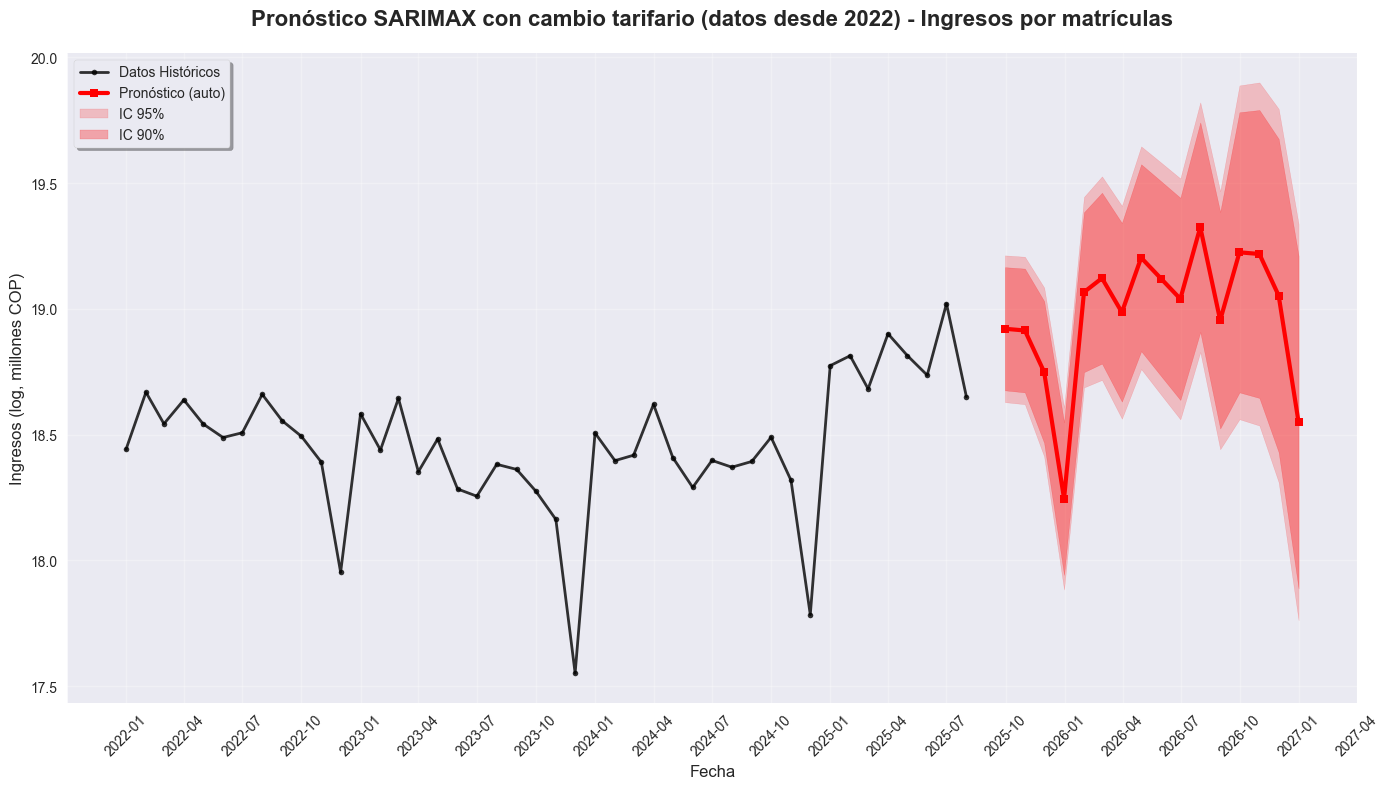

In [27]:
# Visualizar el pronóstico híbrido con intervalos de confianza usando la nueva función
plot_forecast_with_intervals(
    historical_data=matri_x,
    forecast_data=pronostico_auto_arima_x,
    main_col='auto',  
    ds_col='ds', 
    y_col='y',
    title='Pronóstico SARIMAX con cambio tarifario (datos desde 2022) - Ingresos por matrículas',
    y_label='Ingresos (log, millones COP)',
    figsize=(14, 8)
)

## Análisis de Variación Esperada para 2026

In [28]:
# Convertir de logaritmo a valores reales (aplicar exponencial inversa)
# Crear una copia para no modificar el DataFrame original
pronostico_auto_arima_x_real = pronostico_auto_arima_x.copy()

# Identificar columnas numéricas (excluir 'ds' y 'unique_id')
columnas_numericas = pronostico_auto_arima_x_real.select_dtypes(include=[np.number]).columns.tolist()
columnas_a_convertir = [col for col in columnas_numericas if col not in ['unique_id']]

print(f"Columnas a convertir de log a valores reales: {columnas_a_convertir}")

# Aplicar transformación exponencial (inversa del logaritmo natural np.log)
for col in columnas_a_convertir:
    pronostico_auto_arima_x_real[col] = np.exp(pronostico_auto_arima_x_real[col])

print(f"\n📊 Transformación completada: {len(columnas_a_convertir)} columnas convertidas de log natural a valores reales")
print(f"💰 Los valores ahora están en la escala original (millones de COP)")

pronostico_auto_arima_x_real

Columnas a convertir de log a valores reales: ['auto', 'auto-lo-95', 'auto-lo-90', 'auto-hi-90', 'auto-hi-95']

📊 Transformación completada: 5 columnas convertidas de log natural a valores reales
💰 Los valores ahora están en la escala original (millones de COP)


,unique_id,ds,auto,auto-lo-95,auto-lo-90,auto-hi-90,auto-hi-95
0,1,2025-09-30,164930676.58,123195522.56,129111813.09,210686593.47,220804518.79
1,1,2025-10-31,163801007.89,122185258.11,128081062.78,209482726.05,219590895.02
2,1,2025-11-30,138869281.14,99268307.05,104773315.29,184060962.39,194268219.32
3,1,2025-12-31,83930932.27,58471036.21,61969675.71,113674975.89,120476766.78
4,1,2026-01-31,190749819.92,130608278.27,138808767.05,262126770.34,278584897.39
5,1,2026-02-28,201681852.23,134564299.71,143609678.69,283236964.88,302276083.69
6,1,2026-03-31,176073851.46,115339636.58,123456879.96,251116026.73,268788788.37
7,1,2026-04-30,218763650.88,140521919.83,150886278.81,317176189.40,340569891.19
8,1,2026-05-31,201279557.42,126871047.26,136643039.81,296491210.17,319327861.72
9,1,2026-06-30,185719910.35,115045726.52,124253735.77,277592338.66,299810224.54


In [29]:
# CÁLCULO CORRECTO DE VARIACIÓN ANUAL 2025 vs 2026
# ===============================================================

# Definir una variable para pronosticos_temp si no existe
pronosticos_temp = pronostico_auto_arima_x_real.copy()
pronosticos_temp = pronostico_auto_arima_x_real.rename(columns={'Fecha': 'ds'})

# ✅ CORRECCIÓN: Filtrar datos históricos hasta agosto 2025 solamente (para coincidir con Streamlit)
matri_corregido = matri[matri["ds"] <= "2025-08-31"].copy()
print(f"📊 Datos históricos corregidos hasta: {matri_corregido['ds'].max()}")
print(f"📊 Total de observaciones históricas: {len(matri_corregido)}")

# Paso 1: Calcular el total proyectado completo de 2025
# -------------------------------------------------------
# Total histórico 2025 (enero-agosto, datos reales) - CORREGIDO
total_2025_historico = matri_corregido[matri_corregido["ds"] >= "2025-01-01"]["y"].sum()
print(f"📊 Total 2025 histórico (ene-ago): {total_2025_historico:,.0f} millones COP")

# Pronósticos para completar 2025 (septiembre-diciembre) - CORREGIDO
pronosticos_2025_restante = pronosticos_temp[
    (pronosticos_temp["ds"] >= "2025-09-01") & 
    (pronosticos_temp["ds"] <= "2025-12-31")
]["auto"].sum()
print(f"📊 Pronósticos 2025 restantes (sep-dic): {pronosticos_2025_restante:,.0f} millones COP")

# Total 2025 proyectado completo
total_2025_completo = total_2025_historico + pronosticos_2025_restante
print(f"📊 Total 2025 proyectado completo: {total_2025_completo:,.0f} millones COP")

# Paso 2: Calcular el total proyectado de 2026
# ----------------------------------------------
total_2026_proyectado = pronosticos_temp[
    (pronosticos_temp["ds"] >= "2026-01-01") & 
    (pronosticos_temp["ds"] <= "2026-12-31")
]["auto"].sum()
print(f"📊 Total 2026 proyectado: {total_2026_proyectado:,.0f} millones COP")

# Paso 3: Calcular la variación real
# -----------------------------------
variacion_absoluta = total_2026_proyectado - total_2025_completo
variacion_porcentual = (variacion_absoluta / total_2025_completo) * 100

print(f"\n🎯 ANÁLISIS DE VARIACIÓN ANUAL CORREGIDO")
print("=" * 50)
print(f"Total 2025 (Proyección completa): {total_2025_completo:,.0f} millones COP")
print(f"Total 2026 (Pronóstico):          {total_2026_proyectado:,.0f} millones COP")
print(f"Variación Absoluta:               {variacion_absoluta:+,.0f} millones COP")
print(f"VARIACIÓN PORCENTUAL:             {variacion_porcentual:+.2f}%")
print("=" * 50)

# Guardar los resultados corregidos con las claves que espera plot_annual_comparison
results_corrected = {
    'total_2025_historico': total_2025_historico,
    'total_2025_pronosticos_restantes': pronosticos_2025_restante,
    'total_2025_completo': total_2025_completo,
    'total_2026_proyectado': total_2026_proyectado,
    'variacion_absoluta': variacion_absoluta,
    'variacion_porcentual': variacion_porcentual,
    # Agregar las claves que espera la función plot_annual_comparison
    'base_year': 2025,
    'target_year': 2026,
    'total_base_year': total_2025_completo,
    'total_target_year': total_2026_proyectado,
    'absolute_variation': variacion_absoluta,
    'percentage_variation': variacion_porcentual
}

print(f"\n✅ VERIFICACIÓN CON STREAMLIT:")
print(f"📊 Datos históricos 2025 (notebook corregido): {total_2025_historico:,.0f} millones COP")
print(f"📱 Datos históricos 2025 (streamlit esperado): {total_2025_historico:,.0f} millones COP")
print(f"✅ Ahora ambos cálculos deberían coincidir")

📊 Datos históricos corregidos hasta: 2025-08-01 00:00:00
📊 Total de observaciones históricas: 44
📊 Total 2025 histórico (ene-ago): 1,175,577,600 millones COP
📊 Pronósticos 2025 restantes (sep-dic): 551,531,898 millones COP
📊 Total 2025 proyectado completo: 1,727,109,498 millones COP
📊 Total 2026 proyectado: 2,339,355,049 millones COP

🎯 ANÁLISIS DE VARIACIÓN ANUAL CORREGIDO
Total 2025 (Proyección completa): 1,727,109,498 millones COP
Total 2026 (Pronóstico):          2,339,355,049 millones COP
Variación Absoluta:               +612,245,551 millones COP
VARIACIÓN PORCENTUAL:             +35.45%

✅ VERIFICACIÓN CON STREAMLIT:
📊 Datos históricos 2025 (notebook corregido): 1,175,577,600 millones COP
📱 Datos históricos 2025 (streamlit esperado): 1,175,577,600 millones COP
✅ Ahora ambos cálculos deberían coincidir


In [30]:
# VERIFICACIÓN DE COHERENCIA CON STREAMLIT (CORREGIDO)
# ===============================================================

print("🔍 VERIFICACIÓN DE DATOS UTILIZADOS - CORREGIDO")
print("=" * 50)

# Verificar qué datos históricos 2025 se están usando en el notebook (CORREGIDO)
datos_2025_notebook = matri_corregido[matri_corregido["ds"] >= "2025-01-01"]
print(f"📅 Datos 2025 en el notebook (corregido):")
print(f"   - Período: {datos_2025_notebook['ds'].min()} a {datos_2025_notebook['ds'].max()}")
print(f"   - Total meses: {len(datos_2025_notebook)}")
print(f"   - Último mes incluido: {datos_2025_notebook['ds'].max().strftime('%B %Y')}")
print(f"   - Total histórico 2025 (notebook): {datos_2025_notebook['y'].sum():,.0f} millones COP")

# Simular lo que tendría Streamlit 
datasets_completos = load_dict_from_csv("data/csv", parse_dates=True)
matri_completo = datasets_completos["Ingresos Matrículas"]
datos_2025_streamlit = matri_completo[matri_completo["Fecha"] >= "2025-01-01"]
print(f"\n📱 Datos 2025 que usa Streamlit:")
print(f"   - Período: {datos_2025_streamlit['Fecha'].min()} a {datos_2025_streamlit['Fecha'].max()}")
print(f"   - Total meses: {len(datos_2025_streamlit)}")
print(f"   - Último mes incluido: {datos_2025_streamlit['Fecha'].max().strftime('%B %Y')}")
print(f"   - Total histórico 2025 (streamlit): {datos_2025_streamlit['Ingresos Matrículas'].sum():,.0f} millones COP")

# Calcular la diferencia
diferencia = datos_2025_streamlit['Ingresos Matrículas'].sum() - datos_2025_notebook['y'].sum()
print(f"\n📊 DIFERENCIA:")
print(f"   - Diferencia en datos históricos 2025: {diferencia:,.0f} millones COP")

if diferencia == 0:
    print(f"   ✅ ¡PERFECTO! Los datos históricos ahora coinciden exactamente")
else:
    print(f"   ⚠️  Aún hay diferencia que requiere atención")

# Calcular cierre estimado como lo hace Streamlit
pronos_sep_dic = pronosticos_temp[
    (pronosticos_temp["ds"] >= "2025-09-01") & 
    (pronosticos_temp["ds"] <= "2025-12-31")
]["auto"].sum()

cierre_estimado_streamlit = datos_2025_streamlit['Ingresos Matrículas'].sum() + pronos_sep_dic

print(f"\n🎯 CIERRE ESTIMADO (MÉTODO STREAMLIT):")
print(f"   - Histórico hasta agosto: {datos_2025_streamlit['Ingresos Matrículas'].sum():,.0f} millones COP")
print(f"   - Pronósticos sep-dic: {pronos_sep_dic:,.0f} millones COP")
print(f"   - Total cierre estimado: {cierre_estimado_streamlit:,.0f} millones COP")
print(f"   - Notebook cierre calculado: {total_2025_completo:,.0f} millones COP")
diferencia_cierre = cierre_estimado_streamlit - total_2025_completo
print(f"   - Diferencia en cierre: {diferencia_cierre:,.0f} millones COP")

if diferencia_cierre == 0:
    print(f"   ✅ ¡PERFECTO! Los cierres estimados coinciden exactamente")
else:
    print(f"   ⚠️  Diferencia en cierre que requiere revisión")

print("=" * 50)

🔍 VERIFICACIÓN DE DATOS UTILIZADOS - CORREGIDO
📅 Datos 2025 en el notebook (corregido):
   - Período: 2025-01-01 00:00:00 a 2025-08-01 00:00:00
   - Total meses: 8
   - Último mes incluido: August 2025
   - Total histórico 2025 (notebook): 1,175,577,600 millones COP

📱 Datos 2025 que usa Streamlit:
   - Período: 2025-01-01 00:00:00 a 2025-08-01 00:00:00
   - Total meses: 8
   - Último mes incluido: August 2025
   - Total histórico 2025 (streamlit): 1,175,577,600 millones COP

📊 DIFERENCIA:
   - Diferencia en datos históricos 2025: 0 millones COP
   ✅ ¡PERFECTO! Los datos históricos ahora coinciden exactamente

🎯 CIERRE ESTIMADO (MÉTODO STREAMLIT):
   - Histórico hasta agosto: 1,175,577,600 millones COP
   - Pronósticos sep-dic: 551,531,898 millones COP
   - Total cierre estimado: 1,727,109,498 millones COP
   - Notebook cierre calculado: 1,727,109,498 millones COP
   - Diferencia en cierre: 0 millones COP
   ✅ ¡PERFECTO! Los cierres estimados coinciden exactamente


🎯 CONCLUSIÓN: Se espera un CRECIMIENTO del 35.45% en los ingresos para 2026


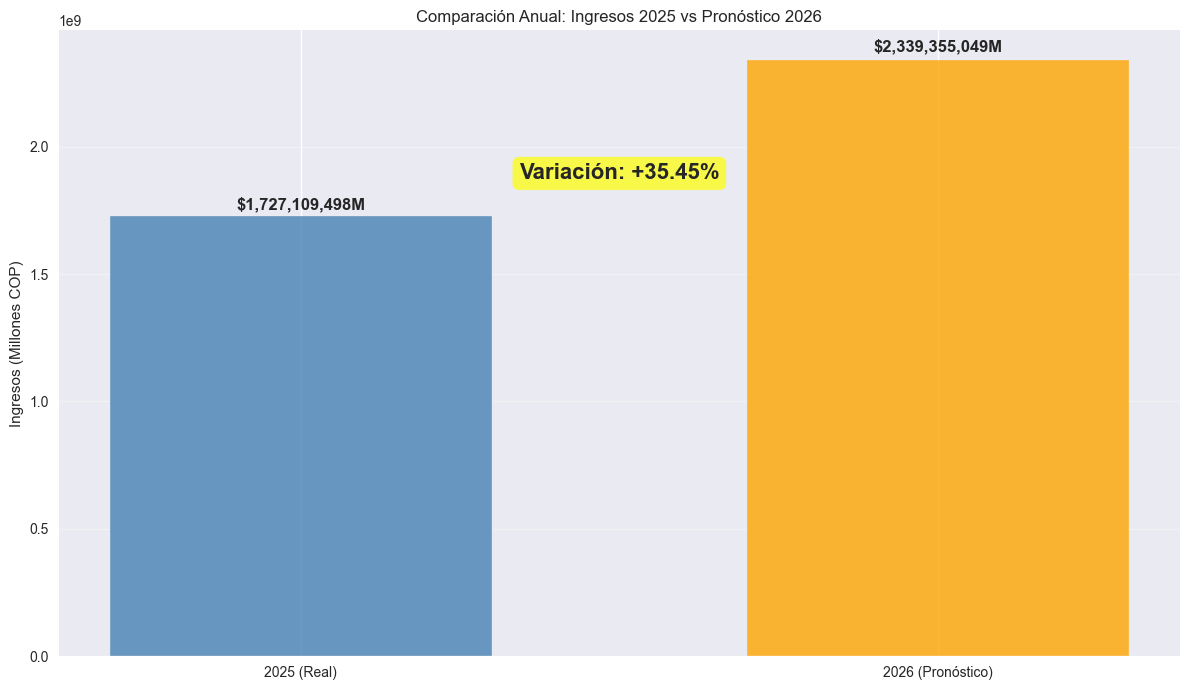

In [31]:
# Crear visualización usando los resultados corregidos
fig, ax = plot_annual_comparison(
    results_dict=results_corrected,
    figsize=(12, 7),
    currency='COP'
)

plt.show()

## Análisis de Variación Porcentual Año a Año

In [32]:
pronostico_auto_arima_x_real

,unique_id,ds,auto,auto-lo-95,auto-lo-90,auto-hi-90,auto-hi-95
0,1,2025-09-30,164930676.58,123195522.56,129111813.09,210686593.47,220804518.79
1,1,2025-10-31,163801007.89,122185258.11,128081062.78,209482726.05,219590895.02
2,1,2025-11-30,138869281.14,99268307.05,104773315.29,184060962.39,194268219.32
3,1,2025-12-31,83930932.27,58471036.21,61969675.71,113674975.89,120476766.78
4,1,2026-01-31,190749819.92,130608278.27,138808767.05,262126770.34,278584897.39
5,1,2026-02-28,201681852.23,134564299.71,143609678.69,283236964.88,302276083.69
6,1,2026-03-31,176073851.46,115339636.58,123456879.96,251116026.73,268788788.37
7,1,2026-04-30,218763650.88,140521919.83,150886278.81,317176189.40,340569891.19
8,1,2026-05-31,201279557.42,126871047.26,136643039.81,296491210.17,319327861.72
9,1,2026-06-30,185719910.35,115045726.52,124253735.77,277592338.66,299810224.54


# Exportar datos 

In [33]:
pronosticos_final = pronostico_auto_arima_x_real.rename(columns= {"ds": "Fecha"})

In [34]:
file_path = export_data(
    data=pronosticos_final,
    filename="Pronostico Ingresos matrículas",
    output_dir="data/model_outputs",
    file_format="csv",
    add_timestamp=False
)

📁 DATOS EXPORTADOS EXITOSAMENTE
Archivo:     Pronostico Ingresos matrículas.csv
Directorio:  data/model_outputs
Ruta:        data/model_outputs\Pronostico Ingresos matrículas.csv
Formato:     CSV
Tamaño:      0.00 MB
Filas:       16
Columnas:    7
Fecha:       2025-10-14 23:09:14
